
===== Logistic Regression =====
Temps : 0.43 sec
              precision    recall  f1-score   support

           0       0.72      0.95      0.82    128733
           1       0.73      0.28      0.41     66625

    accuracy                           0.72    195358
   macro avg       0.73      0.61      0.61    195358
weighted avg       0.72      0.72      0.68    195358



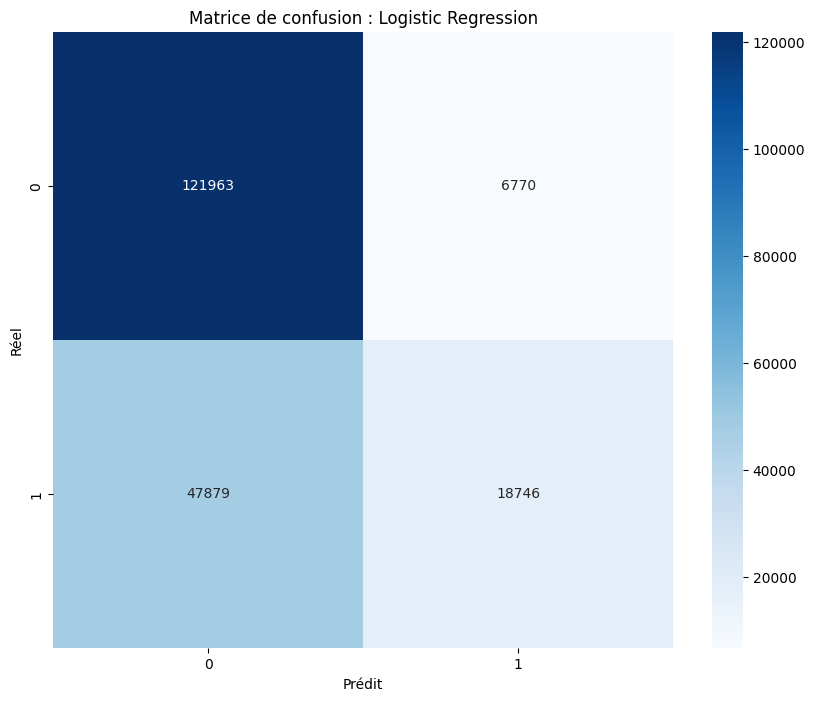


===== Random Forest =====
Temps : 73.46 sec
              precision    recall  f1-score   support

           0       0.82      0.88      0.85    128733
           1       0.73      0.62      0.67     66625

    accuracy                           0.79    195358
   macro avg       0.77      0.75      0.76    195358
weighted avg       0.79      0.79      0.79    195358



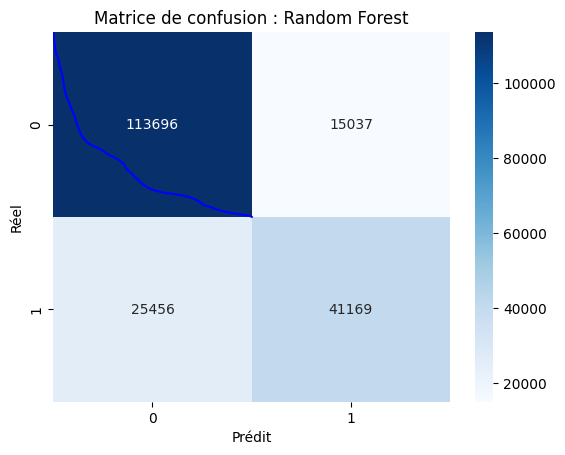

c:\Users\msuch\PycharmProjects\Hexagone\IA_Cyber\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:15:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== XGBoost =====
Temps : 3.59 sec
              precision    recall  f1-score   support

           0       0.81      0.89      0.85    128733
           1       0.73      0.61      0.67     66625

    accuracy                           0.79    195358
   macro avg       0.77      0.75      0.76    195358
weighted avg       0.79      0.79      0.79    195358



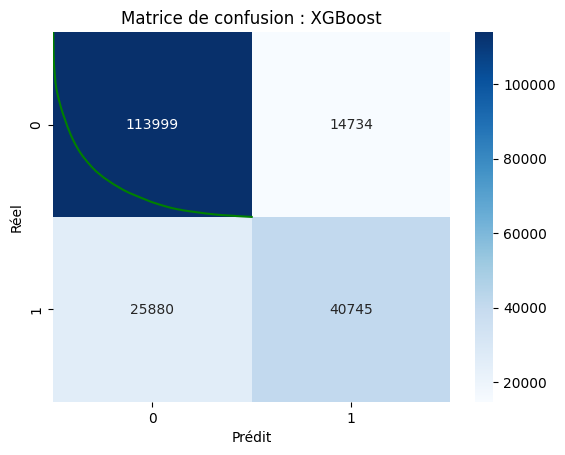

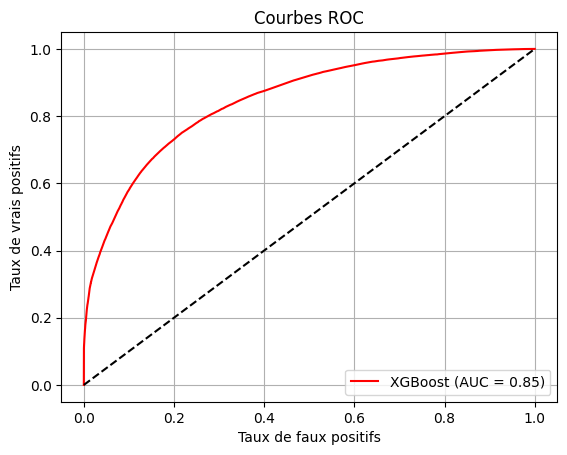

In [3]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import time

# Chargement
df = pd.read_csv("data/malicious_phish.csv")

# Feature extraction
def extract_features(url):
    return {
        'url_length': len(url),
        'num_dots': url.count('.'),
        'num_hyphens': url.count('-'),
        'num_at': url.count('@'),
        'has_ip': int(bool(re.search(r'\d{1,3}(?:\.\d{1,3}){3}', url))),
        'has_https': int('https' in url.lower()),
        'has_login': int('login' in url.lower()),
        'has_free': int('free' in url.lower()),
        'has_update': int('update' in url.lower()),
    }

features = df['url'].apply(lambda x: pd.Series(extract_features(x)))

X = features
y = df['type'].apply(lambda x: 0 if x == 'benign' else 1)

# Prétraitement
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Pour les courbes ROC
plt.figure(figsize=(10, 8))

def train_and_evaluate(model, name, color):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    duration = time.time() - start

    # Classification report + confusion matrix
    print(f"\n===== {name} =====")
    print(f"Temps : {duration:.2f} sec")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion : {name}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=color)

# Modèles
train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression", "blue")
train_and_evaluate(RandomForestClassifier(n_estimators=100), "Random Forest", "green")
train_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost", "red")

# ROC global
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Courbes ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid()
plt.show()
